In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from collections import defaultdict

In [2]:
class GridWorld:
    def __init__(
        self, 
        size=4,
        terminal_states=((0,0), (3,3)), 
        reward=-1
    ):
        self.size = size
        self.terminal_states = terminal_states
        self.reward = reward
        self.actions = ('U', 'D', 'L', 'R')
        self.reset()

    def is_terminal(self, state):
        return state in self.terminal_states
    
    def reset(self):
        self.state = (np.random.randint(self.size), np.random.randint(self.size))
        while self.state in self.terminal_states:
            self.state = (np.random.randint(self.size), np.random.randint(self.size))
        return self.state

    def step(self, action):
        if self.is_terminal(self.state):
            return self.state, 0, True

        x, y = self.state
        if action == 'U': x = max(x - 1, 0)
        if action == 'D': x = min(x + 1, self.size - 1)
        if action == 'L': y = max(y - 1, 0)
        if action == 'R': y = min(y + 1, self.size - 1)
        self.state = (x, y)
        
        return self.state, self.reward, self.is_terminal(self.state)


def uniform_random_policy(state):
    """
    Uniform random policy: returns a random action.
    """
    
    return np.random.choice(['U', 'D', 'L', 'R'])


def generate_episode(env, policy):
    """
    Generates an episode following a given policy.
    """
    
    episode = []
    state = env.reset()
    done = False
    
    while not done:
        action = policy(state)
        
        next_state, reward, done = env.step(action)

        transition = (state, action, reward)
        episode.append(transition)

        state = next_state
    
    return episode


def generate_random_V(env, loc=0, scale=1):
    V = np.random.normal(loc=loc, scale=scale, size=(env.size, env.size))
    for state in env.terminal_states:
        V[state] = 0
    return V


In [3]:
def plot_value_function(V, size=4, episode=0):
    plt.figure(figsize=(6, 6))
    plt.imshow(V, cmap='coolwarm', interpolation='nearest')
    for i in range(size):
        for j in range(size):
            plt.text(j, i, f"{V[i, j]:.1f}", ha='center', va='center', color='black')
    plt.title(f"State Value Function (Episode {episode})")
    plt.colorbar()
    plt.show()

In [4]:
def td_lambda_prediction(env, policy, num_episodes=500, gamma=1.0, alpha=0.1, lambda_=0, V_start=None):

    # Initialize state-value function V(s)
    if V_start is None:
        V = np.zeros((env.size, env.size))
    else:
        V = V_start.copy()

    # For tracking convergence
    V_history = []
    
    # TD-lambda policy evaluation
    for _ in range(num_episodes):

        state = env.reset()
        done = False
        
        # Initialize eligibility traces
        E = np.zeros((env.size, env.size))
        
        while not done:
            # Choose a random action (uniform policy)
            action = uniform_random_policy(state)
            
            # Step in the environment
            next_state, reward, done = env.step(action)
            
            # TD error (delta)
            delta = reward + gamma * V[next_state] - V[state]

            # Decay eligibility traces for all states
            E *= gamma * lambda_

            # Update eligibility trace for current state
            E[state] += 1
            
            # Update state-value function using TD-lambda, for all states
            V += alpha * delta * E
            
            # Move to the next state
            state = next_state

        # Store the sum of absolute values for convergence tracking
        V_history.append(np.abs(V).sum())
    
    return V, V_history

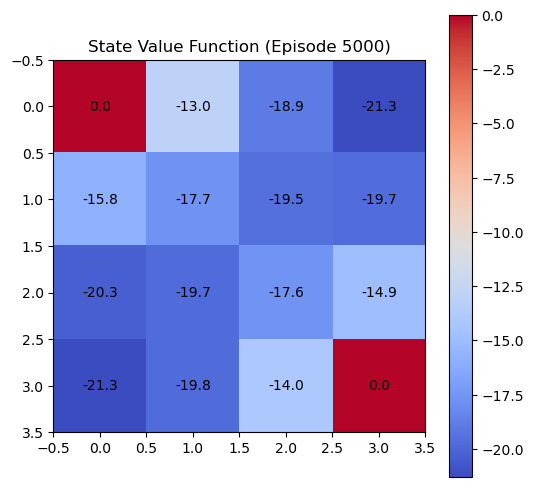

In [5]:
np.random.seed(seed=None)

N = 5_000

env = GridWorld()

V, _ = td_lambda_prediction(
    env=env, 
    policy=uniform_random_policy, 
    num_episodes=N, 
    gamma=1.0, 
    alpha=0.02, 
    lambda_=0.5, 
    V_start=generate_random_V(env, loc=100, scale=5)
)

plot_value_function(V, env.size, N)

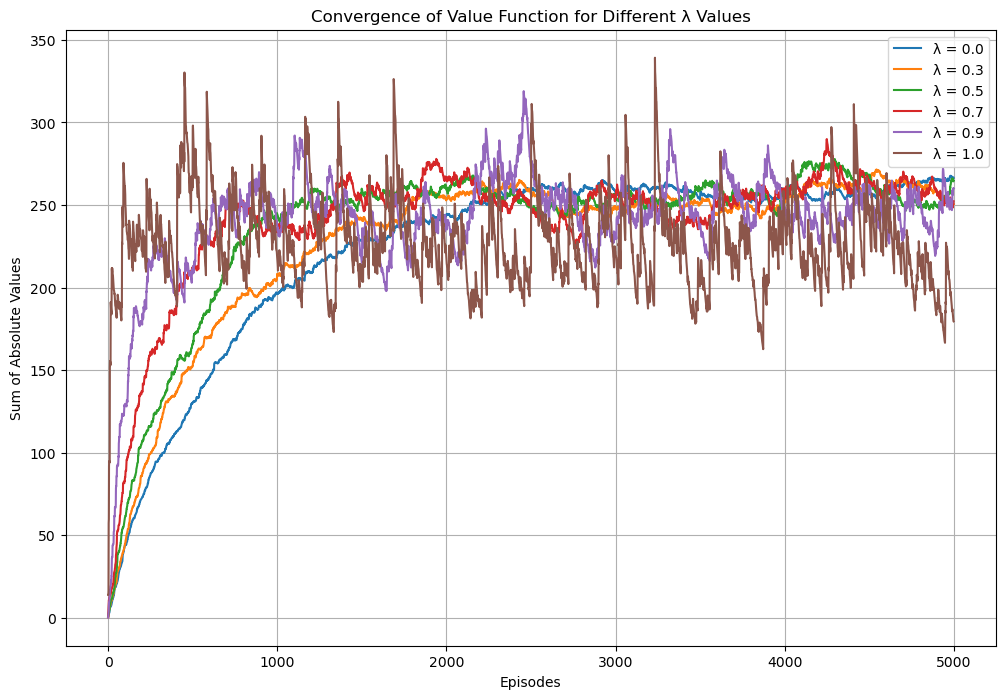

In [6]:
np.random.seed(seed=420)

lambda_values = [0.0, 0.3, 0.5, 0.7, 0.9, 1.0]
V_histories = []
for lambda_ in lambda_values:
    N = 5_000

    env = GridWorld()
    
    _, V_history = td_lambda_prediction(
        env=env, 
        policy=uniform_random_policy, 
        num_episodes=N, 
        gamma=1.0, 
        alpha=0.02, 
        lambda_=lambda_
    )
    V_histories.append(V_history)


# Plot convergence for different lambda values
plt.figure(figsize=(12, 8))
for lambda_, V_history in zip(lambda_values, V_histories):
    plt.plot(V_history, label=f'λ = {lambda_}')

plt.title('Convergence of Value Function for Different λ Values')
plt.xlabel('Episodes')
plt.ylabel('Sum of Absolute Values')
plt.legend()
plt.grid(True)